In [ ]:
# video link: https://www.youtube.com/watch?v=8T2emza6g80


In [1]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
from Bio import SeqIO
import os
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

2024-10-25 11:12:34.656269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-25 11:12:34.656318: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [3]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [4]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [5]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(16)(M1_input)
    M1_dense_2 = Dense(32, activation='relu')(M1_dense_1)
    leaky_relu = LeakyReLU(alpha=0.3)(M1_dense_2)
    drop_out = Dropout(0.5)(leaky_relu)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model


In [6]:
def embedding_model():
    model = Sequential()
    model.add(Embedding(256, 33, input_length=33))
    model.add(Lambda(lambda x: K.expand_dims(x, 3)))
    model.add(Conv2D(64, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.6))
    model.add(Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))
    model.add(Dropout(0.6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(768, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [9]:
train_positive_pt5 = pd.read_csv("../data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("../data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("../data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("../data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('../data/test/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('../data/test/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('../data/train/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('../data/train/fasta/negative_sites.fasta')

# create labels
train_positive_labels = np.ones(train_positive_pt5.shape[0])
train_negative_labels = np.zeros(train_negative_pt5.shape[0])
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])


In [10]:
# stack positive and negative data together
X_train_pt5 = np.vstack((train_positive_pt5, train_negative_pt5))
X_train_embedding = np.vstack((train_positive_embedding,train_negative_embedding))

X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))

y_train = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

In [11]:
# shuffle X and y together
X_train_pt5_full, X_train_embedding_full, y_train = shuffle(X_train_pt5, X_train_embedding, y_train)
X_test_pt5_full, X_test_embedding_full, y_test = shuffle(X_test_pt5, X_test_embedding, y_test)

In [14]:
# combine X_train_pt5, X_train_embedding
X_train_combined = np.hstack([X_train_pt5_full, X_train_embedding_full])

In [15]:
X_train_combined.shape

(9499, 1057)

(7599, 33)
Epoch 1/30
30/30 [==============================] - 18s 577ms/step - loss: 0.8171 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 15s 489ms/step - loss: 0.6937 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 14s 478ms/step - loss: 0.6929 - accuracy: 0.5030 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 14s 475ms/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 14s 480ms/step - loss: 0.6929 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 15s 496ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 14s 477ms/step - loss: 0.6928 - accuracy: 0.5113 - val_loss: 0.6932 - val_accur

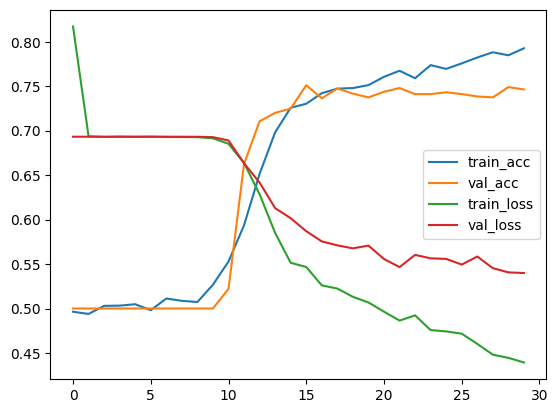

Epoch 1/30
30/30 [==============================] - 1s 11ms/step - loss: 0.6577 - accuracy: 0.6014 - val_loss: 0.6158 - val_accuracy: 0.6684
Epoch 2/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5952 - accuracy: 0.6864 - val_loss: 0.5805 - val_accuracy: 0.7016
Epoch 3/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5662 - accuracy: 0.7094 - val_loss: 0.5579 - val_accuracy: 0.7111
Epoch 4/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5341 - accuracy: 0.7358 - val_loss: 0.5511 - val_accuracy: 0.7137
Epoch 5/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5218 - accuracy: 0.7431 - val_loss: 0.5435 - val_accuracy: 0.7205
Epoch 6/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5083 - accuracy: 0.7558 - val_loss: 0.5456 - val_accuracy: 0.7205
Epoch 7/30
30/30 [==============================] - 0s 5ms/step - loss: 0.4955 - accuracy: 0.7640 - val_loss: 0.5466 - val_accuracy: 0.7200
Epoch 8/30
30/30 [=

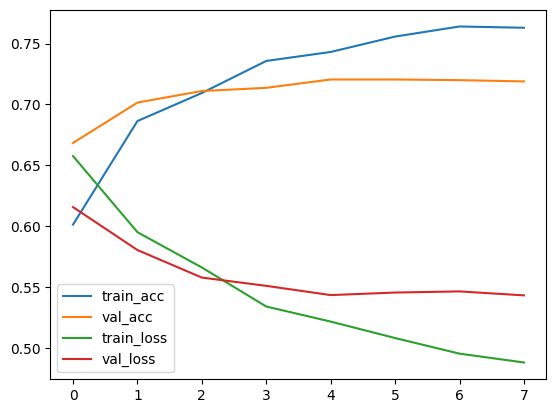

(7599, 33)
Epoch 1/30
30/30 [==============================] - 18s 530ms/step - loss: 0.8540 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 2/30
30/30 [==============================] - 14s 483ms/step - loss: 0.6939 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 14s 481ms/step - loss: 0.6931 - accuracy: 0.5076 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 14s 479ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 14s 480ms/step - loss: 0.6930 - accuracy: 0.5127 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 14s 478ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 14s 477ms/step - loss: 0.6933 - accuracy: 0.4981 - val_loss: 0.6932 - val_accur

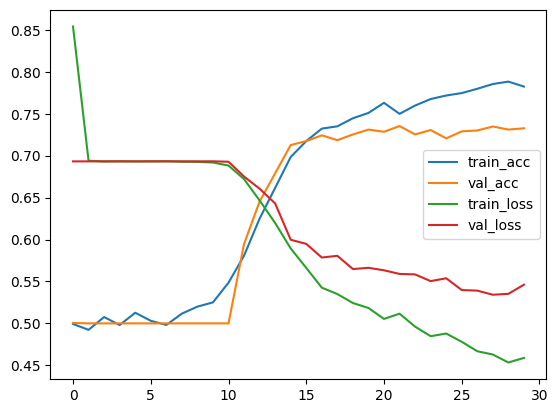

Epoch 1/30
30/30 [==============================] - 1s 10ms/step - loss: 0.6692 - accuracy: 0.5847 - val_loss: 0.6226 - val_accuracy: 0.6679
Epoch 2/30
30/30 [==============================] - 0s 4ms/step - loss: 0.6084 - accuracy: 0.6767 - val_loss: 0.5800 - val_accuracy: 0.6989
Epoch 3/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5713 - accuracy: 0.7100 - val_loss: 0.5592 - val_accuracy: 0.7116
Epoch 4/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5434 - accuracy: 0.7292 - val_loss: 0.5489 - val_accuracy: 0.7168
Epoch 5/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5313 - accuracy: 0.7406 - val_loss: 0.5478 - val_accuracy: 0.7158
Epoch 6/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5170 - accuracy: 0.7512 - val_loss: 0.5408 - val_accuracy: 0.7237
Epoch 7/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5046 - accuracy: 0.7617 - val_loss: 0.5423 - val_accuracy: 0.7253
Epoch 8/30
30/30 [=

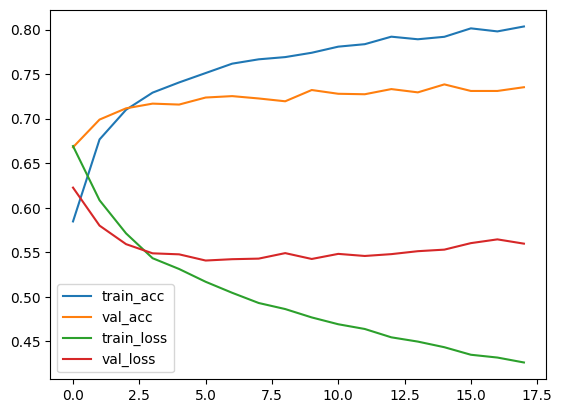

(7599, 33)
Epoch 1/30
30/30 [==============================] - 16s 517ms/step - loss: 0.8300 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 14s 473ms/step - loss: 0.6941 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 14s 470ms/step - loss: 0.6934 - accuracy: 0.4968 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 15s 515ms/step - loss: 0.6935 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5279
Epoch 5/30
30/30 [==============================] - 14s 471ms/step - loss: 0.6928 - accuracy: 0.5094 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 14s 470ms/step - loss: 0.6931 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 14s 470ms/step - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.6931 - val_accur

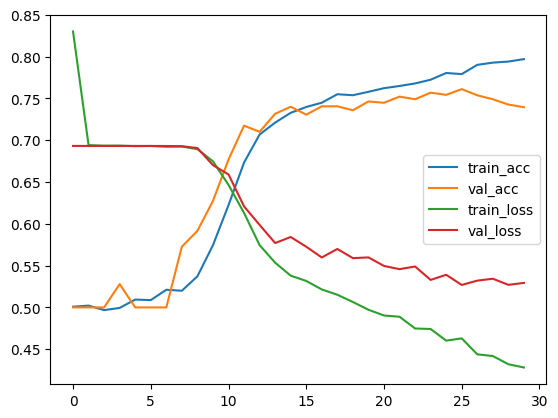

Epoch 1/30
30/30 [==============================] - 1s 11ms/step - loss: 0.6608 - accuracy: 0.5876 - val_loss: 0.6066 - val_accuracy: 0.6811
Epoch 2/30
30/30 [==============================] - 0s 5ms/step - loss: 0.6004 - accuracy: 0.6785 - val_loss: 0.5657 - val_accuracy: 0.7137
Epoch 3/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5678 - accuracy: 0.7109 - val_loss: 0.5506 - val_accuracy: 0.7226
Epoch 4/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5416 - accuracy: 0.7322 - val_loss: 0.5396 - val_accuracy: 0.7274
Epoch 5/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5258 - accuracy: 0.7426 - val_loss: 0.5385 - val_accuracy: 0.7363
Epoch 6/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5136 - accuracy: 0.7493 - val_loss: 0.5313 - val_accuracy: 0.7426
Epoch 7/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5029 - accuracy: 0.7605 - val_loss: 0.5293 - val_accuracy: 0.7453
Epoch 8/30
30/30 [=

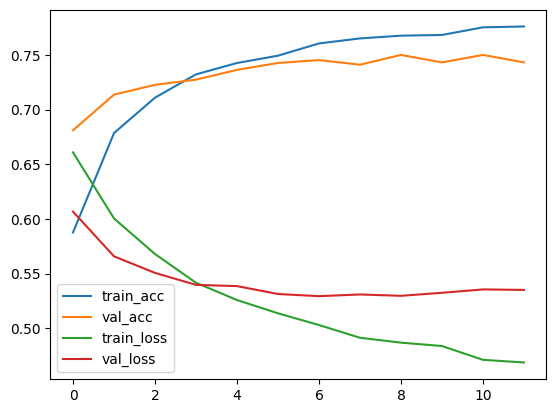

(7599, 33)
Epoch 1/30
30/30 [==============================] - 17s 530ms/step - loss: 0.8497 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 14s 474ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 14s 467ms/step - loss: 0.6930 - accuracy: 0.5102 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 14s 468ms/step - loss: 0.6933 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 14s 467ms/step - loss: 0.6935 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 14s 457ms/step - loss: 0.6931 - accuracy: 0.5090 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 14s 469ms/step - loss: 0.6929 - accuracy: 0.5039 - val_loss: 0.6932 - val_accur

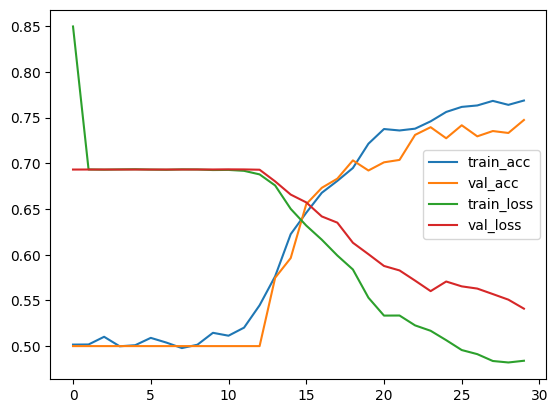

Epoch 1/30
30/30 [==============================] - 1s 11ms/step - loss: 0.6670 - accuracy: 0.5793 - val_loss: 0.6222 - val_accuracy: 0.6695
Epoch 2/30
30/30 [==============================] - 0s 5ms/step - loss: 0.6123 - accuracy: 0.6676 - val_loss: 0.5831 - val_accuracy: 0.7021
Epoch 3/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5720 - accuracy: 0.7096 - val_loss: 0.5676 - val_accuracy: 0.7168
Epoch 4/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5491 - accuracy: 0.7294 - val_loss: 0.5593 - val_accuracy: 0.7132
Epoch 5/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5279 - accuracy: 0.7458 - val_loss: 0.5533 - val_accuracy: 0.7195
Epoch 6/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5168 - accuracy: 0.7537 - val_loss: 0.5548 - val_accuracy: 0.7163
Epoch 7/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5008 - accuracy: 0.7613 - val_loss: 0.5528 - val_accuracy: 0.7184
Epoch 8/30
30/30 [=

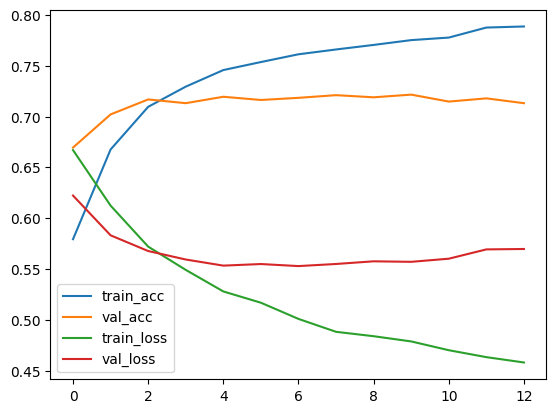

(7600, 33)
Epoch 1/30
30/30 [==============================] - 16s 492ms/step - loss: 0.8133 - accuracy: 0.4941 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 2/30
30/30 [==============================] - 14s 464ms/step - loss: 0.6935 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 3/30
30/30 [==============================] - 15s 510ms/step - loss: 0.6939 - accuracy: 0.4928 - val_loss: 0.6931 - val_accuracy: 0.5134
Epoch 4/30
30/30 [==============================] - 14s 467ms/step - loss: 0.6933 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.5003
Epoch 5/30
30/30 [==============================] - 14s 465ms/step - loss: 0.6927 - accuracy: 0.5150 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 6/30
30/30 [==============================] - 15s 499ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5434
Epoch 7/30
30/30 [==============================] - 14s 471ms/step - loss: 0.6926 - accuracy: 0.5109 - val_loss: 0.6931 - val_accur

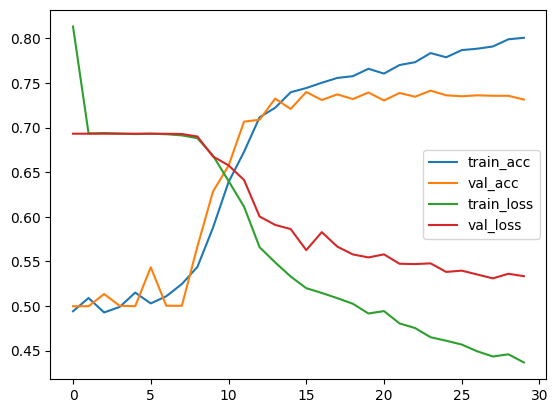

Epoch 1/30
30/30 [==============================] - 1s 12ms/step - loss: 0.6706 - accuracy: 0.5734 - val_loss: 0.6220 - val_accuracy: 0.6672
Epoch 2/30
30/30 [==============================] - 0s 5ms/step - loss: 0.6030 - accuracy: 0.6813 - val_loss: 0.5787 - val_accuracy: 0.6956
Epoch 3/30
30/30 [==============================] - 0s 6ms/step - loss: 0.5642 - accuracy: 0.7157 - val_loss: 0.5625 - val_accuracy: 0.7046
Epoch 4/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5395 - accuracy: 0.7337 - val_loss: 0.5534 - val_accuracy: 0.7162
Epoch 5/30
30/30 [==============================] - 0s 4ms/step - loss: 0.5231 - accuracy: 0.7424 - val_loss: 0.5515 - val_accuracy: 0.7199
Epoch 6/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5133 - accuracy: 0.7563 - val_loss: 0.5459 - val_accuracy: 0.7246
Epoch 7/30
30/30 [==============================] - 0s 5ms/step - loss: 0.5046 - accuracy: 0.7595 - val_loss: 0.5480 - val_accuracy: 0.7225
Epoch 8/30
30/30 [=

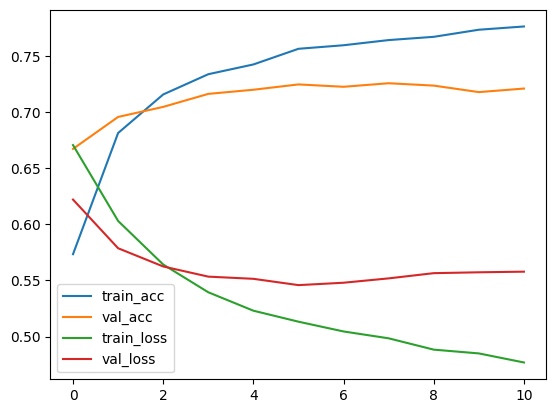

In [37]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(5, shuffle=True, random_state=1)
iteration = 1

# Define metric before using it
metric = 'val_accuracy'

for train, val in kfold.split(X_train_combined, y_train):
    train_X, val_X = X_train_combined[train], X_train_combined[val]
    train_y, val_y = y_train[train], y_train[val]
    
    # Split data
    X_train_embedding = train_X[:,1024:]
    X_train_prot_t5 = train_X[:,:1024]
    X_val_embedding = val_X[:,1024:]
    X_val_prot_t5 = val_X[:,:1024]
    
    print(X_train_embedding.shape)
    
    # MODEL A
    model_A = embedding_model()
    model_A.compile(optimizer=Adam(learning_rate=1e-3),
                   loss=BinaryCrossentropy(),
                   metrics=['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath="../models/st_model_best.h5",
                                 monitor=metric,
                                 verbose=0, 
                                 save_weights_only=False,
                                 save_best_only=True)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    patience=7,
                                                    mode='auto')
    
    history_A = model_A.fit(X_train_embedding, train_y, 
                          batch_size=256,
                          epochs=30,
                          verbose=1,
                          callbacks=[checkpointer],
                          validation_data=(X_val_embedding, val_y))
    
    # Save model
    model_A.save(f'../models/cv_new/model_A_{iteration}.h5')
    
    #save plot
    plot_save(history_A, f'../models/cv_new/curves/model_A_{iteration}.png')
    
    # MODEL B
    model_B = prot_t5_model()
    model_B.compile(optimizer=Adam(learning_rate=1e-3),
                   loss=BinaryCrossentropy(),
                   metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    patience=3,
                                                    mode='auto')
    
    history_B = model_B.fit(X_train_prot_t5, train_y, 
                          batch_size=256,
                          epochs=30,
                          verbose=1,
                          callbacks=[early_stopping],
                          validation_data=(X_val_prot_t5, val_y))
    
    # Save model
    model_B.save(f'../models/cv_new/model_B_{iteration}.h5')
    
    #save plot
    plot_save(history_B, f'../models/cv_new/curves/model_B_{iteration}.png')
    
    iteration += 1

## After training models

In [27]:
# save models
# model_1.save('../models/model_1.h5')
# model_2.save('../models/model_2.h5')
# model_3.save('../models/model_3.h5')

In [28]:
# open saved models
# model_1 = load_model('../models/model_1.h5')
# model_2 = load_model('../models/model_2.h5')
# model_3 = load_model('../models/model_3.h5')

In [38]:
# load models from file
def load_all_models(model_names):
    all_models = list()
    for model in model_names:
        filename = '../models/cv_new/'+ model + '.h5'
        model = load_model(filename)
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
#             layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(4, activation='relu', name = 'ds_1')(merge)
#     hidden = Dropout(0.4, name = 'dp_1')(hidden)
#     hidden = Dense(4, activation='relu', name = 'ds_2')(hidden)

#     hidden = Dense(4, activation='relu', name = 'ds_3')(hidden)
#     hidden = Reshape((1,4))(hidden)
#     hidden = Bidirectional(LSTM(32))(hidden)
#     hidden = Dropout(0.4, name = 'dp_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    plot_model(model, show_shapes=True, to_file='ensemble_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# fit a model
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    model.fit(X, inputy_enc, epochs=10, verbose=1)   


# prediction
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.predict(X, verbose=0)


# load all models
members = load_all_models(['model_A_1', 'model_A_2', 'model_A_3', 'model_A_4', 'model_A_5', 'model_B_1', 'model_B_2', 'model_B_3', 'model_B_4', 'model_B_5'])
print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)
# fit_stacked_model(stacked_model, x_test, y_test)
st_history = stacked_model.fit([X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full],y_train,validation_split=0.2, epochs=10, verbose=1)

>loaded ../models/cv_new/model_A_1.h5
>loaded ../models/cv_new/model_A_2.h5
>loaded ../models/cv_new/model_A_3.h5
>loaded ../models/cv_new/model_A_4.h5
>loaded ../models/cv_new/model_A_5.h5
>loaded ../models/cv_new/model_B_1.h5
>loaded ../models/cv_new/model_B_2.h5
>loaded ../models/cv_new/model_B_3.h5
>loaded ../models/cv_new/model_B_4.h5
>loaded ../models/cv_new/model_B_5.h5
Loaded 10 models
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/10
238/238 [==============================] - 34s 135ms/step - loss: 0.5803 - accuracy: 0.6814 - val_loss: 0.5506 - val_accuracy: 0.7142
Epoch 2/10
238/238 [==============================] - 31s 130ms/step - loss: 0.4806 - accuracy: 0.7987 - val_loss: 0.4688 - val_accuracy: 0.8095
Epoch 3/10
238/238 [==============================] - 30s 126ms/step - loss: 0.4169 - accuracy: 0.8384 - val_loss: 0.4084 - val_accuracy: 0.8526
Epoch 

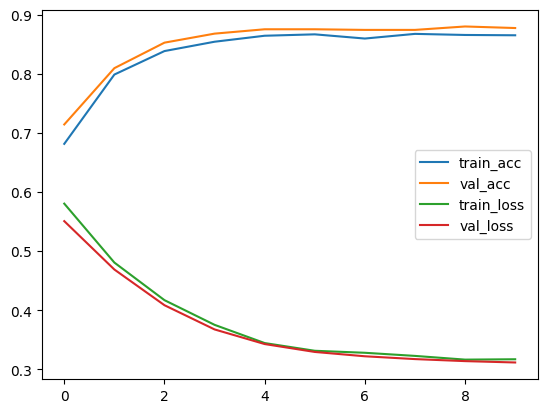

In [39]:
plot(st_history)

In [40]:
# Prediction with stacked model
y_pred = stacked_model.predict([
    X_test_embedding_full, X_test_embedding_full, X_test_embedding_full, 
    X_test_embedding_full, X_test_embedding_full,
    X_test_pt5_full, X_test_pt5_full, X_test_pt5_full, 
    X_test_pt5_full, X_test_pt5_full
])
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
y_test = np.array(y_test)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Matthews Correlation : ",matthews_corrcoef(y_test, y_pred))
print("Confusion Matrix :\n",confusion_matrix(y_test, y_pred))
print("Accuracy on test set:   ",accuracy_score(y_test,y_pred))
print("Sensitivity : ",cm[1][1]/(cm[1][1]+cm[1][0]))
print("Specificity: ",cm[0][0]/(cm[0][0]+cm[0][1]))

Matthews Correlation :  0.3329239731659767
Confusion Matrix :
 [[2252  721]
 [  50  203]]
Accuracy on test set:    0.7610043397396157
Sensitivity :  0.8023715415019763
Specificity:  0.7574840228725194


101/101 [==============================] - 8s 74ms/step

Model Performance Metrics:
------------------------------
Matthews Correlation: 0.3329
Accuracy on test set: 0.7610
Sensitivity (Recall): 0.8024
Specificity: 0.7575

Confusion Matrix:
------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative           2252                721
Actual Positive             50                203

Detailed Classification Report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.76      0.85      2973
         1.0       0.22      0.80      0.34       253

    accuracy                           0.76      3226
   macro avg       0.60      0.78      0.60      3226
weighted avg       0.92      0.76      0.81      3226



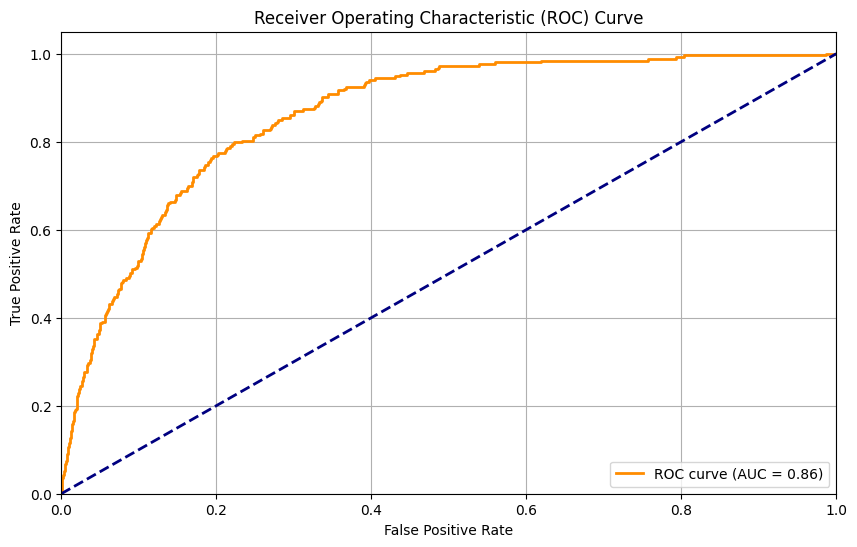

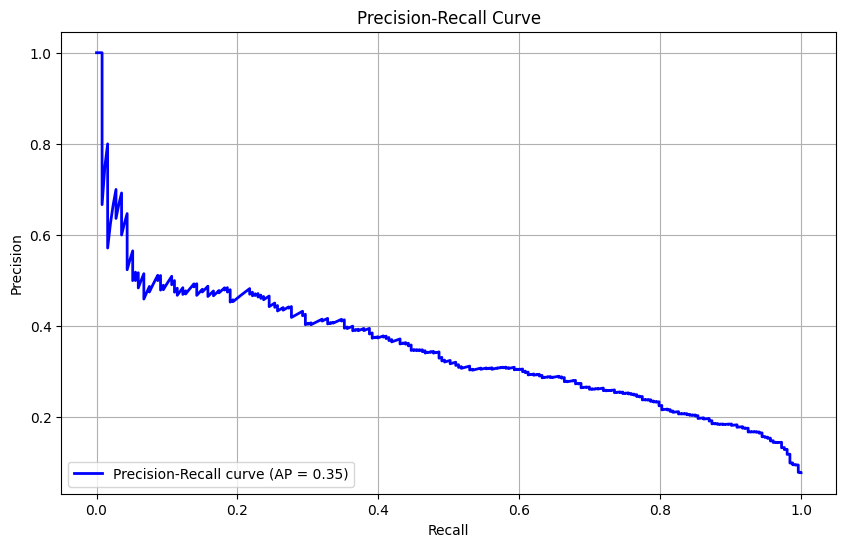

In [42]:
# Prediction with stacked model
y_pred_proba = stacked_model.predict([
    X_test_embedding_full, X_test_embedding_full, X_test_embedding_full, 
    X_test_embedding_full, X_test_embedding_full,
    X_test_pt5_full, X_test_pt5_full, X_test_pt5_full, 
    X_test_pt5_full, X_test_pt5_full
], verbose=1)

# Convert to binary predictions
y_pred = (y_pred_proba > 0.5).flatten()
y_pred = y_pred.astype(int)

# Ensure y_test is the correct shape
y_test = np.array(y_test)
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

# Calculate confusion matrix and metrics
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Print basic metrics
print("\nModel Performance Metrics:")
print("-" * 30)
print(f"Matthews Correlation: {matthews_corrcoef(y_test, y_pred):.4f}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_pred):.4f}")
print(f"Sensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")

# Print confusion matrix with labels
print("\nConfusion Matrix:")
print("-" * 30)
print("                 Predicted Negative  Predicted Positive")
print(f"Actual Negative       {tn:8d}           {fp:8d}")
print(f"Actual Positive       {fn:8d}           {tp:8d}")

# Additional metrics
from sklearn.metrics import classification_report, precision_score, f1_score, roc_auc_score

print("\nDetailed Classification Report:")
print("-" * 30)
print(classification_report(y_test, y_pred))

# Calculate and plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('../models/cv_new/roc_curve.png')
plt.show()

# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('../models/cv_new/precision_recall_curve.png')
plt.show()

# Save predictions to file
results_df = pd.DataFrame({
    'True_Labels': y_test,
    'Predicted_Labels': y_pred,
    'Prediction_Probability': y_pred_proba.flatten()
})
results_df.to_csv('../models/cv_new/prediction_results.csv', index=False)

In [43]:
# stacked_model.summary()
plot_model(stacked_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
